In [1]:
#!/usr/bin/env python

# importing default libraries
SEED=91
# to get reproducible results
import os
import sys
# import tensorflow as tf
# tf.random.set_seed(SEED)

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)

np.random.seed(SEED)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

**** scripts/config.py IMPORTED!!!
**** PROJECT FOLDER ,  /home/pgundogdu/projects/signalization_prior_knowledge_based_nn


In [2]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow import keras

# importing scripts in scripts folder
from scripts import config as src

FIGURE_TITLE_SIZE = 18
SUBPLOT_TITLE_SIZE = 14
LEGEND_TITLE_SIZE = 12
FONT_SIZE = 10

plt.rc('font', size=FONT_SIZE)                # controls default text sizes
plt.rc('axes', titlesize=SUBPLOT_TITLE_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('legend', title_fontsize=LEGEND_TITLE_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FIGURE_TITLE_SIZE)  # fontsize of the figure title

In [6]:
def convert_to_tsne(X1, y1, X2, y2, model1, model2, info1, info2):
    np.random.seed(SEED)
    df_encoding_1 = pd.DataFrame(model1.predict(X1))
    df_encoding_2 = pd.DataFrame(model2.predict(X2))
    tsne = TSNE()

    df_tsne_1_array = tsne.fit_transform(np.array(df_encoding_1))
    df_tsne_1 = pd.DataFrame(df_tsne_1_array, columns=['tsne1', 'tsne2'])
    df_tsne_1['cell_type'] = y1
    df_tsne_1['dataset'] = info1

    df_tsne_2_array = tsne.fit_transform(np.array(df_encoding_2))
    df_tsne_2 = pd.DataFrame(df_tsne_2_array, columns=['tsne1', 'tsne2'])
    df_tsne_2['cell_type'] = y2
    df_tsne_2['dataset'] = info2

    df_encoding = pd.concat([df_tsne_1, df_tsne_2]).reset_index(drop=True)
    return df_encoding

## MELANOMA

In [3]:
# loc = './reports/encoding/exper_melanoma'
split = 'train_test_split'
experiment = 'exper_melanoma'
loc_read = glob.glob(os.path.join(src.DIR_MODELS, experiment, f'{split}*'))[0]

df_unseen = pd.read_pickle('./data/processed/exper_melanoma/query_log1p.pck')
# df = df[df['cell_type']!='Neg.cell'].reset_index(drop=True)
X_unseen = df_unseen.iloc[:, :-1].values
y_ground_truth_unseen = df_unseen.iloc[:, -1:]


# df_seen = pd.read_pickle('./data/processed/exper_melanoma/reference_log1p.pck')
# # df = df[df['cell_type']!='Neg.cell'].reset_index(drop=True)
# X_seen = df_seen.iloc[:, :-1].values
# y_ground_truth_seen = df_seen.iloc[:, -1:]


print('shape of feature and traget dataset, feature dataset, {0}, target column {1}'.format(X_unseen.shape, y_ground_truth_unseen.shape))
# print('shape of feature and traget dataset, feature dataset, {0}, target column {1}'.format(X_seen.shape, y_ground_truth_seen.shape))

shape of feature and traget dataset, feature dataset, (3412, 17994), target column (3412, 1)


In [4]:
# print(glob.glob(os.path.join(loc_read, f'encoding*_layer*'))[0])
model_1_layer = keras.models.load_model( glob.glob(os.path.join(loc_read, f'encoding*1_layer*'))[0] , compile=False)
model_2_layer = keras.models.load_model( glob.glob(os.path.join(loc_read, f'encoding*2_layer*'))[0] , compile=False)

In [5]:
order_plot = list(np.unique(y_ground_truth_unseen))
order_plot.remove('Neg.cell')
order_plot.append('Neg.cell')
plot_label = dict(zip(order_plot, range(len(order_plot))))
plot_label

{'B.cell': 0, 'Macrophage': 1, 'NK': 2, 'T.CD4': 3, 'T.CD8': 4, 'Neg.cell': 5}

In [7]:
df_encoding = convert_to_tsne(X1=X_unseen
                              , y1=y_ground_truth_unseen
                              , X2=X_unseen
                              , y2=y_ground_truth_unseen
                              , model1=model_1_layer
                              , model2=model_2_layer
                              , info1='1_layer'
                              , info2='2_layer')

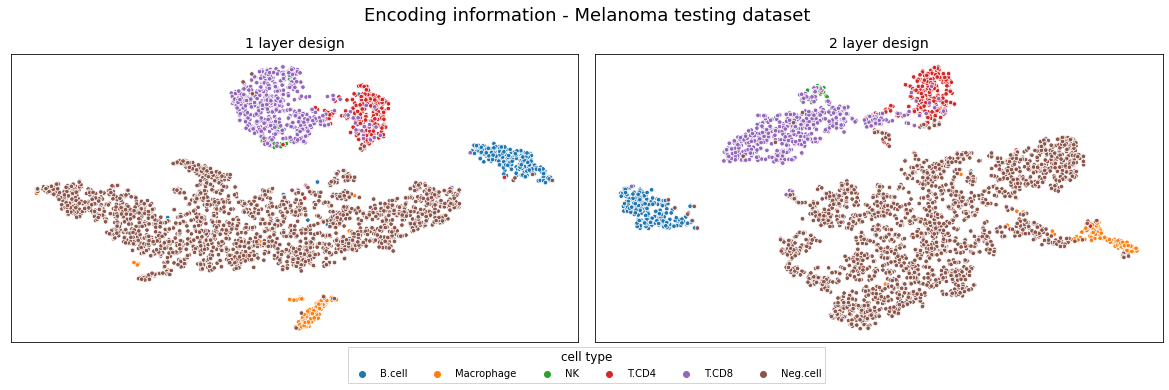

In [9]:
fig, axes= plt.subplots(ncols=2, figsize=(20,5))

# df_encoding_tsne_seen = df_encoding[df_encoding['dataset']=='training'].iloc[:, :-1]
# df_encoding_tsne_seen = df_encoding_tsne_seen.sort_values(by=['cell_type'], key=lambda x: x.map(seen_label))
df_encoding_tsne_1_layer = df_encoding[df_encoding['dataset']=='1_layer'].iloc[:, :-1]
df_encoding_tsne_1_layer = df_encoding_tsne_1_layer.sort_values(by=['cell_type'], key=lambda x: x.map(plot_label))

df_encoding_tsne_2_layer = df_encoding[df_encoding['dataset']=='2_layer'].iloc[:, :-1]
df_encoding_tsne_2_layer = df_encoding_tsne_2_layer.sort_values(by=['cell_type'], key=lambda x: x.map(plot_label))

sns.scatterplot(data=df_encoding_tsne_1_layer, x='tsne1', y='tsne2', hue='cell_type', ax=axes[0], marker='.', s=80)
sns.scatterplot(data=df_encoding_tsne_2_layer, x='tsne1', y='tsne2', hue='cell_type', ax=axes[1], marker='.', s=80)

axes[0].get_legend().remove()
axes[0].set_title(f'1 layer design')

axes[1].get_legend().remove()
axes[1].set_title(f'2 layer design')

axes[0].axes.get_yaxis().set_visible(False)
axes[0].axes.get_xaxis().set_visible(False)

axes[1].axes.get_yaxis().set_visible(False)
axes[1].axes.get_xaxis().set_visible(False)

handles, labels = axes[1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', title='cell type', bbox_to_anchor=(.5, 0.05)
                 , fancybox=False, shadow=False, ncol=6)
fig.suptitle(f'Encoding information - Melanoma testing dataset')
plt.subplots_adjust(left=0.1,
                        bottom=0.05, 
                        right=0.9, 
                        top=0.85, 
                        wspace=0.03, 
                        hspace=.4);

plt.savefig(f'./reports/encoding/{experiment}/melanoma_ENC_circuits_paper2.png', dpi=300, bbox_inches = 'tight')
plt.savefig(f'./reports/encoding/{experiment}/melanoma_ENC_circuits_paper2.pdf', dpi=300, bbox_inches = 'tight')
plt.savefig(f'./reports/encoding/{experiment}/melanoma_ENC_circuits_paper2.tiff', dpi=300, bbox_inches = 'tight')

## IMMUNE

In [16]:
# loc = './reports/encoding/exper_melanoma'
split = 'train_test_split'
experiment = 'exper_immune'
loc_read = glob.glob(os.path.join(src.DIR_MODELS, experiment, f'{split}*'))[0]

df_immune = pd.read_pickle('./data/processed/exper_immune/immune_new.pck')
# df = df[df['cell_type']!='Neg.cell'].reset_index(drop=True)
X_immune = df_immune.iloc[:, :-1].values
y_ground_truth_immune = df_immune.iloc[:, -1:]

print('shape of feature and traget dataset, feature dataset, {0}, target column {1}'.format(X_immune.shape, y_ground_truth_immune.shape))
# print('shape of feature and traget dataset, feature dataset, {0}, target column {1}'.format(X_seen.shape, y_ground_truth_seen.shape))

shape of feature and traget dataset, feature dataset, (9456, 19595), target column (9456, 1)


In [17]:
order_plot = list(np.unique(y_ground_truth_immune))
# order_plot.remove('Neg.cell')
# order_plot.append('Neg.cell')
plot_label = dict(zip(order_plot, range(len(order_plot))))
plot_label

{'b': 0, 'e': 1, 'mo': 2, 'n': 3, 'nk': 4, 'sp': 5, 't': 6}

In [18]:
# print(glob.glob(os.path.join(loc_read, f'encoding*_layer*'))[0])
model_1_layer = keras.models.load_model( glob.glob(os.path.join(loc_read, f'encoding*1_layer*'))[0] , compile=False)
model_2_layer = keras.models.load_model( glob.glob(os.path.join(loc_read, f'encoding*2_layer*'))[0] , compile=False)

In [19]:
df_encoding_immune = convert_to_tsne(X1=X_immune
                                     , y1=y_ground_truth_immune
                                     , X2=X_immune
                                     , y2=y_ground_truth_immune
                                     , model1=model_1_layer
                                     , model2=model_2_layer
                                     , info1='1_layer'
                                     , info2='2_layer')

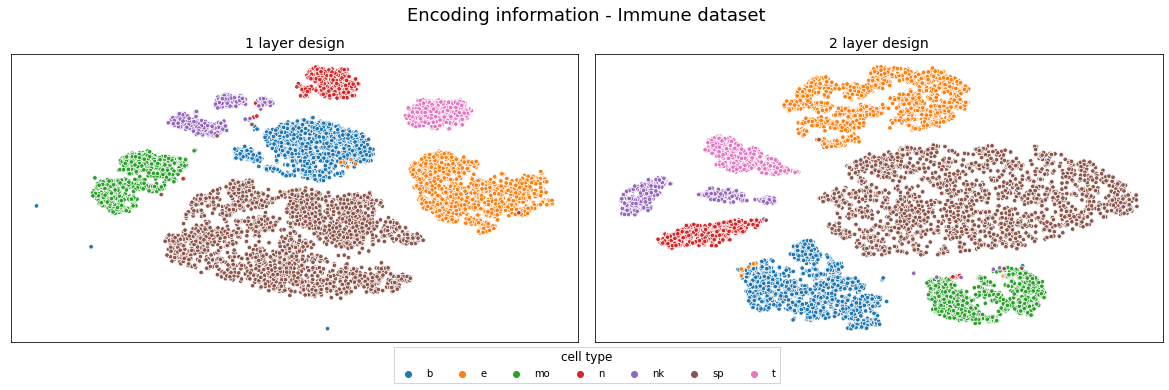

In [21]:
fig, axes= plt.subplots(ncols=2, figsize=(20,5))

# df_encoding_tsne_seen = df_encoding[df_encoding['dataset']=='training'].iloc[:, :-1]
# df_encoding_tsne_seen = df_encoding_tsne_seen.sort_values(by=['cell_type'], key=lambda x: x.map(seen_label))
df_encoding_tsne_1_layer = df_encoding_immune[df_encoding_immune['dataset']=='1_layer'].iloc[:, :-1]
df_encoding_tsne_1_layer = df_encoding_tsne_1_layer.sort_values(by=['cell_type'], key=lambda x: x.map(plot_label))

df_encoding_tsne_2_layer = df_encoding_immune[df_encoding_immune['dataset']=='2_layer'].iloc[:, :-1]
df_encoding_tsne_2_layer = df_encoding_tsne_2_layer.sort_values(by=['cell_type'], key=lambda x: x.map(plot_label))

sns.scatterplot(data=df_encoding_tsne_1_layer, x='tsne1', y='tsne2', hue='cell_type', ax=axes[0], marker='.', s=80)
sns.scatterplot(data=df_encoding_tsne_2_layer, x='tsne1', y='tsne2', hue='cell_type', ax=axes[1], marker='.', s=80)

axes[0].get_legend().remove()
axes[0].set_title(f'1 layer design')

axes[1].get_legend().remove()
axes[1].set_title(f'2 layer design')

axes[0].axes.get_yaxis().set_visible(False)
axes[0].axes.get_xaxis().set_visible(False)

axes[1].axes.get_yaxis().set_visible(False)
axes[1].axes.get_xaxis().set_visible(False)

handles, labels = axes[1].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', title='cell type', bbox_to_anchor=(.5, 0.05)
                 , fancybox=False, shadow=False, ncol=7)
fig.suptitle(f'Encoding information - Immune dataset')
plt.subplots_adjust(left=0.1,
                        bottom=0.05, 
                        right=0.9, 
                        top=0.85, 
                        wspace=0.03, 
                        hspace=.4);

plt.savefig(f'./reports/encoding/{experiment}/immune_ENC_circuits_paper2.png', dpi=300, bbox_inches = 'tight')
plt.savefig(f'./reports/encoding/{experiment}/immune_ENC_circuits_paper2.pdf', dpi=300, bbox_inches = 'tight')
plt.savefig(f'./reports/encoding/{experiment}/immune_ENC_circuits_paper2.tiff', dpi=300, bbox_inches = 'tight')